# Fiding optimal number of segments to approximate an equation y = f(x)

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# Define functions to approximate

# y = ax^4 + bx^3 + cx^2 + dx + f
def f_quarticn(x):
    a = -0.0179516
    b = 0.331323
    c = -1.53398
    d = -0.21107
    f = 5.73434
    x = x + 1
    return a*x**4 + b*x**3 + c*x**2 + d*x + f

def f_quartic(x):
    a = -0.0179516
    b = 0.331323
    c = -1.63398
    d = 1.01107
    f = 5.73434
    return a*x**4 + b*x**3 + c*x**2 + d*x + f
    
def f_inv_quartic(x):
    return 7 - f_quartic(x)
    
def f_semicircle(x):
    maxX = x.max()
    minX = x.min()
    radius = (maxX - minX)/2 
    center = (maxX + minX)/2 
    y = np.sqrt(np.abs(radius**2 - (x-center)**2))
    return y
    
def frand(y):
    return y + y*np.random.uniform(-0.1, 0.1, y.shape).astype('f')

def normalize(x,y):
    mu_x = torch.mean(x)
    std_x = torch.std(x)

    mu_y = torch.mean(y)
    std_y = torch.std(y)

    x_normalized = torch.nn.functional.normalize(x - mu_x, dim=0)
    y_normalized = torch.nn.functional.normalize(y - mu_y, dim=0)
    return x_normalized.numpy(), y_normalized.numpy()

In [3]:
#Create data set
np.random.seed(10)
f = f_quartic # select data function
xs = np.arange(-1.5, 11., .05)
ys = f(xs)
n = xs.shape[0]
# try normalization
xs, ys = normalize(torch.tensor(xs), torch.tensor(ys))

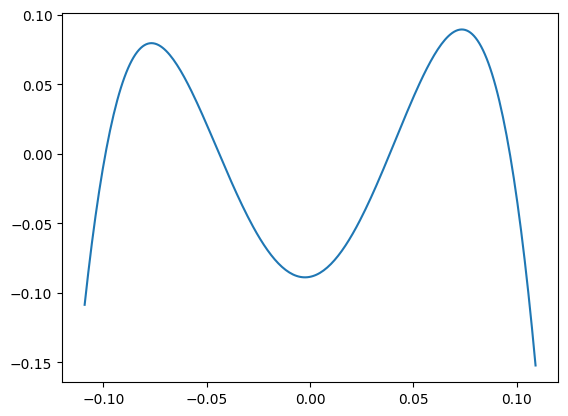

In [4]:
plt.plot(xs,ys)

## Find loss for each segment
* Step 1: Start making segment with three consecutive points. 
* Step 2: Sort segments by ascending loss. Also calculate total loss for all segments and average loss.
* Step 3: Extend 3 point segment to 4 points by adding point in the higher x side, repeat step 2.

In [5]:
# For given set of x,y define segment (weight, bias and x_min, x_max)
from collections import namedtuple

# Define a namedtuple
Segment = namedtuple('Segment', ['w', 'b', 'x_min', 'x_max', 'loss', 'n_points'])

def make_segment(x, y):
    """
    Calculates the best fit line for a given x and y numpy array.
    
    Args:
    x: A numpy array of x-coordinates.
    y: A numpy array of y-coordinates.
    
    Returns:
    w: The slope of the best fit line.
    b: The y-intercept of the best fit line.
    """
    # Calculate the mean of x and y
    mean_x = x.mean()
    mean_y = y.mean()
    
    # Calculate the slope (m) and y-intercept (b)
    if(np.sum((x - mean_x)**2) == 0):
        print("Error: divided by zero for ", x, mean_x)
        return
    w = np.sum((x - mean_x) * (y - mean_y)) / np.sum((x - mean_x)**2)
    b = mean_y - w * mean_x
    n_points = len(x)
    
    # Calculate sum of absolute loss for a given segment
    y_pred = w*x + b
    loss = np.abs((y - y_pred)/y)
    
    return Segment(w, b, x.min(), x.max(), loss.sum(), n_points)

  

In [7]:
def make_n_segments(n_points, xs, ys):
    segments = []
    n = len(xs)
    for i in range(0,n - n_points + 1, n_points-1):
        #print(i, len(xs[i:i+n_points]), xs[i:i+n_points])
        segments.append(make_segment(xs[i:i+n_points], ys[i:i+n_points]))
    # do we have residue greater than 1 point?
    if (i+n_points < n-1):
        #print("residue ", i, len(xs[i+n_points:n]), xs[i+n_points:n])
        segments.append(make_segment(xs[i+n_points:n], ys[i+n_points:n]))
    return segments

# find position of a segment in segments
def find_segment_pos(segment, segments):
    for i in range(len(segments)):
        if segments[i].x_min == segment.x_min:
            return i
            break
    return -1

### N point equal segments

n_points: 3  total loss : 0.0038046272576582624  total segments: 124


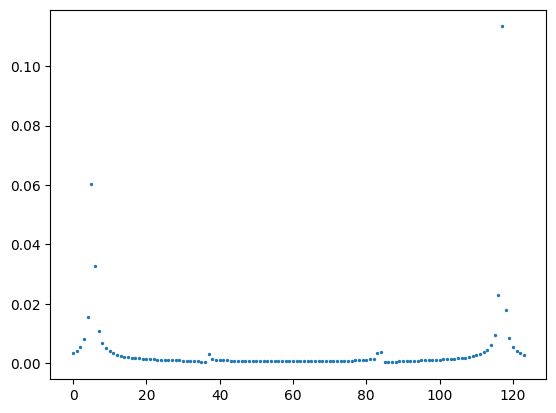

In [8]:
def plot_segments(n_points = 3):
    segments = make_n_segments(n_points, xs, ys)
    # plot loss
    loss = [segment.loss for segment in segments]
    print("n_points:",n_points, " total loss :",np.mean(loss), " total segments:",len(segments))
    plt.scatter(np.arange(len(loss)), loss,s=2)

plot_segments(3)

n_points: 25  total loss : 2.493113273403976  total segments: 11


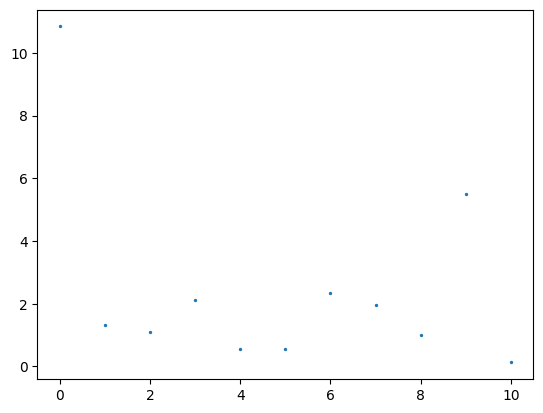

In [9]:
plot_segments(25)

## Create uneven point segments based on sorted loss
goal should be to see if we can have loss less than 10 segments loss above
* start with lowest loss segment, expand it in each direction till the loss for segment is higher than next segment
* reorder segments by loss and operate on lowest loss segment

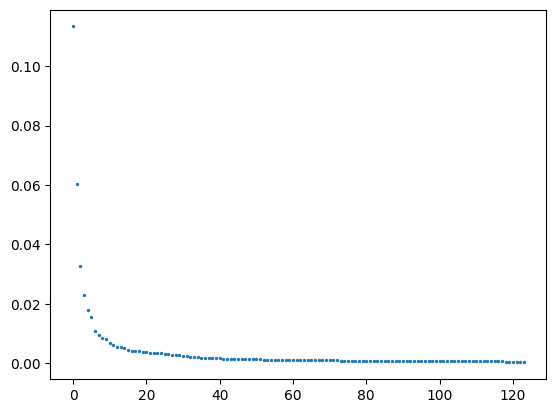

In [10]:
from operator import attrgetter

segments = make_n_segments(3, xs, ys)
# Sort the list by loss
sorted_segments = sorted(segments, key=attrgetter('loss'), reverse=True)

# plot sorted loss to see outliers
sorted_loss = [segment.loss for segment in sorted_segments]
plt.scatter(np.arange(len(sorted_segments)), sorted_loss,s=2)

In [ ]:
sorted_segments[0:4]

In [55]:
# OBSERVATIONS: Looks like this optimization is basically dividing X into different segments then
# finding best fit line in each segment in order to reduce the total loss
# Take the segment with max loss and try to distribute its edge points to nearby segments to reduce loss
# step 1: find the change in total loss (for both segments) if we shift beginning point to previous segment
# step 2: find the change in total loss (for both segments) if we shift end point to next segment
# step 3: pick the step that reduces most loss
# step 4: continue to reduce loss 
def optimize(segments, max_steps=0):
    at = 0 # The highest loss segment we want to reduce.
    loss = [segment.loss for segment in segments]
    print ("starting loss = ", np.sum(loss))
    for counter in range(200):
        # reverse sort segments so we can work on highest loss first
        #print("segments",segments)
        sorted_segments = sorted(segments, key=attrgetter('loss'), reverse=True) 
        #print("sorted_segments",sorted_segments)
        # Find the indices of x_min, x_max in the X input array so we can expand segment in either direction
        adjusted = False
        segment = sorted_segments[at]
        pos = find_segment_pos(segment, segments)
        if pos < 0:
            print ("got no position for segment",segment, segments)
            break
        # STEP 1: Expand left
        net_step_1_loss_reduction = 0
        if pos > 0:
            # We are not the 1st segment so we can give our start point to prev segment
            prev_segment = segments[pos-1]
            old_loss_step_1 = segment.loss + prev_segment.loss
            #find the start and end index values for this segment
            start, stop = np.searchsorted(xs,segment.x_min),np.searchsorted(xs,segment.x_max) 
            # drop the 1st point
            x = xs[start+1:stop+1]
            y = ys[start+1:stop+1]
            # do we have enough points to be a segment? else break
            if(len(x) == 0):
                print (f"Can't reduce segment {pos} further, aborting")
                break
            new_segment_by_step_1 = make_segment(x, y)
            # now recreate prev segment by adding this point.
            start, stop = np.searchsorted(xs,prev_segment.x_min),np.searchsorted(xs,prev_segment.x_max) 
            x = xs[start:stop+2]
            y = ys[start:stop+2]
            new_prev_segment = make_segment(x, y)
            new_loss_step_1 = new_segment_by_step_1.loss + new_prev_segment.loss
            net_step_1_loss_reduction = old_loss_step_1 - new_loss_step_1
            
        # STEP 2: Expand right if this segment is not the last
        net_step_2_loss_reduction = 0
        if pos < len(segments)-1:
            next_segment = segments[pos+1]
            old_loss_step_2 = segment.loss + next_segment.loss
            # drop last point
            #find the start and end index values for this segment
            start, stop = np.searchsorted(xs,segment.x_min),np.searchsorted(xs,segment.x_max) 
            x = xs[start:stop]
            y = ys[start:stop]
            if(len(x) <= 1):
                print (f"Can't reduce segment {pos} further, aborting")
                break
            new_segment_by_step_2 = make_segment(x, y)
            # now create next segment by adding this point.
            start, stop = np.searchsorted(xs,next_segment.x_min),np.searchsorted(xs,next_segment.x_max) 
            x = xs[start-1:stop+1]
            y = ys[start-1:stop+1]
            if(len(x) == 0):
                print (f"Can't reduce segment {pos} further, aborting")
                break
            new_next_segment = make_segment(x, y)
            new_loss_step_2 = new_segment_by_step_2.loss + new_next_segment.loss
            net_step_2_loss_reduction = old_loss_step_2 - new_loss_step_2

        # STEP 3: pick the step that reduces most loss
        if net_step_1_loss_reduction > net_step_2_loss_reduction and net_step_1_loss_reduction > 0:
            segments[pos] = new_segment_by_step_1
            segments[pos-1] = new_prev_segment
            adjusted = True
        elif net_step_2_loss_reduction > 0:
            segments[pos] = new_segment_by_step_2
            segments[pos+1] = new_next_segment   
            adjusted = True
            
        loss = [segment.loss for segment in segments]
        n_points = [segment.n_points for segment in segments]
        #print ("counter:", counter, "new loss:",np.sum(loss), " segments: ",len(loss), " min points:", np.min(n_points),
        #       " max points:", np.max(n_points))
        if (not adjusted):
            print ("Optimal state reached at counter = ", counter, " for at = ", at, " loss = ", np.sum(loss))
            at = at + 1
            if(at > len(segments)-2):
                print ("total optimization reached. end")
                break #we have reached optimal state
        if(max_steps > 0 and counter + 1 >= max_steps):
            print ("Max steps reached.")
            break
            
    return segments

In [12]:
#plot the function with segments
def plot_segments(segments):
    x_points = []
    y_points = []
    for segment in segments:
        x = segment.x_min
        y = segment.w*x+segment.b
        x_points.append(x)
        y_points.append(y)
        #print(x,y)
    # Add end point from last segment
    x = segment.x_max
    y = segment.w*x+segment.b
    x_points.append(x)
    y_points.append(y)
    return x_points, y_points


n_points =  51 Total Segments =  5  total loss =  75.14646586162672


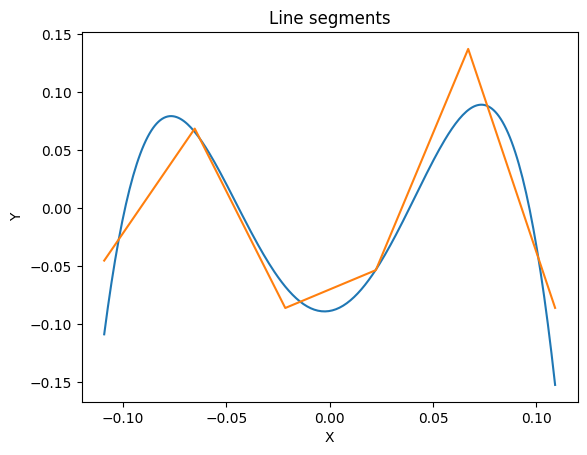

In [64]:

import matplotlib.pyplot as plt

# Define x and y coordinates
n_points = 51
segments = make_n_segments(n_points, xs, ys)
loss = [segment.loss for segment in segments]
print("n_points = ", n_points, "Total Segments = ", len(segments), " total loss = ", np.sum(loss))
x_points, y_points = plot_segments(segments)

# Plot the segments
plt.plot(xs, ys)
plt.plot(x_points, y_points)

# Add labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Line segments')

# Show the plot
plt.show()


In [ ]:
#optimize 
new_segments = optimize(segments, 100)

starting loss =  67.32472181775216


n_points =  51 Total Segments =  5  total loss =  67.32472181775216


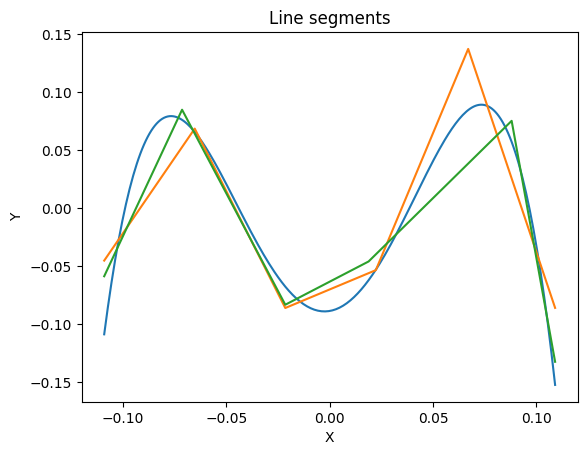

In [70]:
#plot the change frop optimization
import matplotlib.pyplot as plt

# Define x and y coordinates
#segments = make_n_segments(n_points, xs, ys)
loss = [segment.loss for segment in new_segments]
print("n_points = ", n_points, "Total Segments = ", len(segments), " total loss = ", np.sum(loss))
# Plot the segments
plt.plot(xs, ys)
plt.plot(x_points, y_points)

new_x_points, new_y_points = plot_segments(new_segments)
# Plot the segments
plt.plot(new_x_points, new_y_points)

# Add labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Line segments')

# Show the plot
plt.show()

## Notes & Observations
Able to reduce loss by optimization
#### before optimize
n_points =  60 Total Segments =  5  total loss =  140.55025913597157
#### after optimize
n_points =  60 Total Segments =  5  total loss =  63.56628750245597
#### no change for n_points = 63

## Try all segment size and effect of opimize

In [62]:
points = range(51,63)
seg_size = []
losses = []
optmized_losses = []
for n_points in points:
    segments = make_n_segments(n_points, xs, ys)
    seg_size.append(len(segments))
    loss = [segment.loss for segment in segments]
    losses.append(np.sum(loss))
    segments = optimize(segments)
    loss = [segment.loss for segment in segments]
    optmized_losses.append(np.sum(loss))
    print(n_points, seg_size[-1],losses[-1], optmized_losses[-1])
    

starting loss =  75.14646586162672
Optimal state reached at counter =  26  for at =  0  loss =  69.9714221758284
Optimal state reached at counter =  27  for at =  1  loss =  69.9714221758284
Optimal state reached at counter =  28  for at =  2  loss =  69.9714221758284
Optimal state reached at counter =  33  for at =  3  loss =  67.88445402194486
total optimization reached. end
51 5 75.14646586162672 67.88445402194486
starting loss =  76.1251409341717
Optimal state reached at counter =  10  for at =  0  loss =  75.13072803420259
Optimal state reached at counter =  20  for at =  1  loss =  72.02040592039842
Optimal state reached at counter =  21  for at =  2  loss =  72.02040592039842
Optimal state reached at counter =  25  for at =  3  loss =  69.80756363840555
total optimization reached. end
52 5 76.1251409341717 69.80756363840555
starting loss =  78.31429877969941
Optimal state reached at counter =  0  for at =  0  loss =  78.31429877969941
Optimal state reached at counter =  12  for 

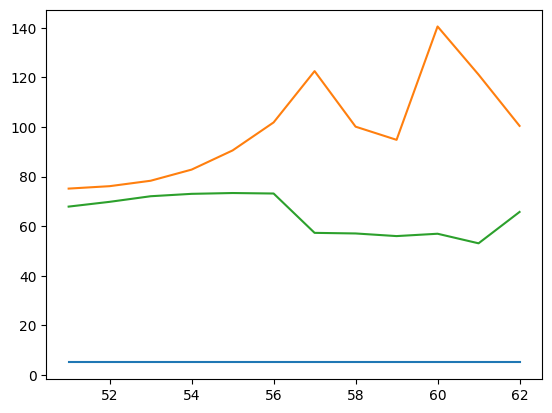

In [63]:
plt.plot(points, seg_size)
plt.plot(points, losses)
plt.plot(points, optmized_losses)

In [30]:
loss_diff = np.array(losses)-np.array(optmized_losses)

In [31]:
losses[0], optmized_losses[0]

(88.71216337875799, 61.944529545915884)

In [32]:
np.where(np.array(seg_size) == 5)

(array([ 3,  4,  5,  6,  7,  8,  9, 10]),)

### SCRATCH AREA BELOW 

In [ ]:
loss =  np.zeros(n-2, dtype=np.float32)
locx =  np.zeros(n-2, dtype=np.float32)
locy =  np.zeros(n-2, dtype=np.float32)
for i in range(1,n-1):
    loss[i-1] = np.abs(ys[i]-ys[i-1] - ((ys[i+1] - ys[i-1])/(xs[i+1] - xs[i-1])*(xs[i]-xs[i-1])))
    locx[i-1] = xs[i]
    locy[i-1] = ys[i]

In [ ]:
# Sort the data by loss in ascending order
# Sort both arrays together using lexicographic sorting
indices = np.lexsort([loss])

sorted_loss = loss[indices]
sorted_locx = locx[indices]
sorted_locy = locy[indices]

In [ ]:
# Get cumulatibe loss
cum_loss = np.cumsum(sorted_loss)
segments = np.arange(n-2,0,-1)
# plot the cumulative loss against segments
plt.scatter(cum_loss, segments,s=1)

In [ ]:
plt.plot(locx, loss)
#plt.plot(xs,ys)

In [ ]:
# Based on this information we can decide how many segments to keep.
# if we keep m segments then we keep m-1 points from the end of locx. These will be the intersect, but how do we draw segments?

# Looks like we have to recalculate loss and reorder points after we remove one (or replace its y value with calculated y). It needs to be iterative.

In [ ]:
m=124
plt.plot(xs,ys,c='w')
plt.scatter(locx[indices[:m]], locy[indices[:m]],s=2,c='r')
#plt.scatter(locx[indices[:m]], loss[indices[:m]],s=2,c='b')
plt.scatter(locx[indices[-m:]], locy[indices[-m:]],s=2,c='g')
#plt.scatter(locx[indices[-m:]], loss[indices[-m:]],s=2,c='y')

In [ ]:
indices[0:5]